In [1]:
# -*- coding: utf-8 -*-
"""similarpic-round-3.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1zCYESCC926945l22op4_nu4F2smddWoK
"""

"""
RONDA 3 - GENERAR EMBEDDINGS VISUALES (PREGUNTA 2 DEL PROYECTO)
=================================================================

Propósito:
- Generar embeddings (vectores) de todas las imágenes del dataset
- Usar CLIP (Contrastive Language-Image Pre-training) de OpenAI
- Estos embeddings capturan características visuales de las prendas
- Permitirán búsqueda de similitud para recomendaciones

Inputs (requiere):
  - df_clean.csv (todas las imágenes)
  - Carpeta de imágenes

Outputs:
  - embeddings_all.npy (~90 MB)
  - embeddings_metadata.json
  - embeddings_visualization.png

"""

# ============================================
# FIX: PROTOBUF COMPATIBILITY
# ============================================
import os
import sys

# Fix protobuf version conflict BEFORE importing anything else
try:
    import subprocess
    print("🔧 Verificando protobuf...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "protobuf==3.20.3"])
    print("✅ Protobuf corregido")
except Exception as e:
    print(f"⚠️ No se pudo instalar protobuf: {e}")

# Clear any cached imports
if 'google.protobuf' in sys.modules:
    del sys.modules['google.protobuf']

# ============================================
# IMPORTS
# ============================================
from pathlib import Path
import time
import json

# Data
import pandas as pd
import numpy as np
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# CLIP
from transformers import CLIPProcessor, CLIPModel

# Visualización
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("  RONDA 3 - GENERAR EMBEDDINGS VISUALES CON CLIP")
print("  Pregunta 2: ¿Qué prendas son visualmente similares?")
print("=" * 70)

# ============================================
# CONFIGURACIÓN
# ============================================

IS_KAGGLE = os.path.exists('/kaggle/input')
IS_COLAB = 'COLAB_GPU' in os.environ

print(f"\n🖥️ Entorno: {'Kaggle' if IS_KAGGLE else 'Colab' if IS_COLAB else 'Local'}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🎮 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("   ⚠️ GPU no disponible. Procesamiento será lento.")

# Rutas
if IS_KAGGLE:
    base_path = Path('/kaggle/input/fashion-product-images-dataset/fashion-dataset')
    if not base_path.exists():
        base_path = Path('/kaggle/input/fashion-product-images-dataset')
    data_dir = Path('/kaggle/working')
    output_dir = Path('/kaggle/working')
elif IS_COLAB:
    import kagglehub
    path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
    base_path = Path(path) / "fashion-dataset"
    if not base_path.exists():
        base_path = Path(path)
    data_dir = Path('/content/fashion_processed')
    output_dir = Path('/content/fashion_processed')
else:
    base_path = Path('./data/raw')
    data_dir = Path('./data/processed')
    output_dir = Path('./models')

images_path = base_path / "images"
output_dir.mkdir(parents=True, exist_ok=True)

print(f"\n📂 Rutas:")
print(f"   - Imágenes: {images_path}")
print(f"   - Output: {output_dir}")

# Hiperparámetros
BATCH_SIZE = 32  # CLIP es más ligero que EfficientNet
NUM_WORKERS = 2
EMBEDDING_DIM = 512  # Dimensión de CLIP ViT-B/32

print(f"\n⚙️ Configuración:")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Embedding dimension: {EMBEDDING_DIM}")

# ============================================
# 1. CARGAR CLIP
# ============================================

print("\n" + "=" * 70)
print("[1/6] CARGANDO MODELO CLIP")
print("=" * 70)

# Instalar si es necesario
try:
    from transformers import CLIPProcessor, CLIPModel
except ImportError:
    print("⚠️ transformers no instalado. Instalando...")
    os.system("pip install -q transformers")
    from transformers import CLIPProcessor, CLIPModel

# Cargar CLIP preentrenado
model_name = "openai/clip-vit-base-patch32"
print(f"\n📥 Descargando {model_name}...")

clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)

clip_model = clip_model.to(device)
clip_model.eval()  # Modo evaluación

print(f"✅ CLIP cargado exitosamente")
print(f"   - Modelo: ViT-B/32")
print(f"   - Embedding dim: {EMBEDDING_DIM}")
print(f"   - Parámetros: {sum(p.numel() for p in clip_model.parameters()):,}")

# ============================================
# 2. DATASET PARA EMBEDDINGS
# ============================================

print("\n[2/6] PREPARANDO DATASET")

class EmbeddingDataset(Dataset):
    """Dataset simple para generar embeddings"""

    def __init__(self, dataframe, images_dir, processor):
        self.df = dataframe.reset_index(drop=True)
        self.images_dir = Path(images_dir)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(row['id'])

        # Cargar imagen
        img_path = self.images_dir / f"{img_id}.jpg"

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Fallback: imagen negra
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            print(f"⚠️ Error cargando {img_path}: {e}")

        # Procesar con CLIP processor
        inputs = self.processor(images=image, return_tensors="pt")

        # Retornar pixel_values y metadata
        return inputs['pixel_values'].squeeze(0), img_id, idx

# Cargar dataset completo (df_clean.csv)
# En Kaggle, primero revisar en datasets de input, luego en working
if IS_KAGGLE:
    # Buscar en múltiples ubicaciones posibles
    possible_csv_paths = [
        Path('/kaggle/input/df-clean/df_clean.csv'),  # Dataset df-clean
        Path('/kaggle/input/dfclean/df_clean.csv'),   # Sin guión
        data_dir / "df_clean.csv",  # Working directory
    ]
    
    csv_path = None
    for path in possible_csv_paths:
        if path.exists():
            csv_path = path
            print(f"✅ CSV encontrado en: {csv_path}")
            break
    
    if csv_path is None:
        print("❌ ERROR: No se encontró df_clean.csv")
        print("\n🔍 Ubicaciones buscadas:")
        for path in possible_csv_paths:
            print(f"   - {path} {'(existe)' if path.exists() else '(no existe)'}")
        print("\n💡 Solución:")
        print("   1. Añade el dataset 'df-clean' a tu notebook en Kaggle")
        print("   2. O ejecuta 'Ronda 1' primero para generar df_clean.csv")
        raise FileNotFoundError("df_clean.csv no encontrado")
else:
    csv_path = data_dir / "df_clean.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"❌ No se encontró {csv_path}. Ejecuta Ronda 1 primero.")

df = pd.read_csv(csv_path)
print(f"✅ Dataset cargado: {len(df):,} productos")

# Crear dataset y loader
embedding_dataset = EmbeddingDataset(df, images_path, clip_processor)
embedding_loader = DataLoader(
    embedding_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # IMPORTANTE: mantener orden
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ DataLoader creado: {len(embedding_loader)} batches")
print(f"   Total imágenes a procesar: {len(df):,}")

# ============================================
# 3. GENERAR EMBEDDINGS
# ============================================

print("\n[3/6] GENERANDO EMBEDDINGS")
print("Esto puede tomar 1-2 horas dependiendo de la GPU...")

all_embeddings = []
all_img_ids = []
all_indices = []

start_time = time.time()

with torch.no_grad():
    for batch_images, batch_ids, batch_indices in tqdm(embedding_loader, desc="Generando embeddings"):
        batch_images = batch_images.to(device)

        # Forward pass con CLIP (solo la parte de visión)
        image_features = clip_model.get_image_features(pixel_values=batch_images)

        # Normalizar embeddings (importante para similitud de coseno)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Guardar en CPU
        all_embeddings.append(image_features.cpu().numpy())
        all_img_ids.extend(batch_ids)
        all_indices.extend(batch_indices.tolist())

# Concatenar todos los embeddings
embeddings = np.vstack(all_embeddings)

elapsed_time = time.time() - start_time
print(f"\n✅ Embeddings generados!")
print(f"   - Shape: {embeddings.shape}")
print(f"   - Dtype: {embeddings.dtype}")
print(f"   - Rango: [{embeddings.min():.3f}, {embeddings.max():.3f}]")
print(f"   - Norma promedio: {np.linalg.norm(embeddings, axis=1).mean():.3f}")
print(f"   - Tiempo total: {elapsed_time/60:.1f} min")
print(f"   - Velocidad: {len(df)/(elapsed_time/60):.0f} imágenes/min")

# Sanity check
assert embeddings.shape[0] == len(df), "Número de embeddings no coincide con dataset"
assert embeddings.shape[1] == EMBEDDING_DIM, f"Dimensión incorrecta: {embeddings.shape[1]} vs {EMBEDDING_DIM}"
assert len(all_img_ids) == len(df), "Número de IDs no coincide"

print("✅ Sanity checks pasados")

# ============================================
# 4. GUARDAR EMBEDDINGS
# ============================================

print("\n[4/6] GUARDANDO EMBEDDINGS")

# Archivo principal de embeddings (numpy)
embeddings_path = output_dir / "embeddings_all.npy"
np.save(embeddings_path, embeddings)
file_size_mb = embeddings_path.stat().st_size / (1024 * 1024)
print(f"✅ Embeddings guardados: {embeddings_path}")
print(f"   - Tamaño: {file_size_mb:.1f} MB")

# Metadata de embeddings
metadata = {
    'model': model_name,
    'embedding_dim': EMBEDDING_DIM,
    'num_embeddings': int(embeddings.shape[0]),
    'img_ids': all_img_ids,
    'indices': all_indices,
    'normalization': 'L2 normalized',
    'generated_at': time.strftime('%Y-%m-%d %H:%M:%S'),
    'processing_time_min': elapsed_time / 60,
    'device': str(device),
    'statistics': {
        'mean': float(embeddings.mean()),
        'std': float(embeddings.std()),
        'min': float(embeddings.min()),
        'max': float(embeddings.max()),
        'norm_mean': float(np.linalg.norm(embeddings, axis=1).mean()),
        'norm_std': float(np.linalg.norm(embeddings, axis=1).std())
    }
}

metadata_path = output_dir / "embeddings_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Metadata guardada: {metadata_path}")

# ============================================
# 5. VISUALIZAR EMBEDDINGS
# ============================================

print("\n[5/6] VISUALIZANDO EMBEDDINGS")

# Tomar muestra para visualización (t-SNE es costoso)
max_samples = 5000
if len(embeddings) > max_samples:
    print(f"⚠️ Tomando muestra de {max_samples:,} embeddings para visualización...")
    sample_indices = np.random.choice(len(embeddings), max_samples, replace=False)
    embeddings_sample = embeddings[sample_indices]
    df_sample = df.iloc[sample_indices].reset_index(drop=True)
else:
    embeddings_sample = embeddings
    df_sample = df.copy()

# t-SNE (lento pero mejor visualización)
print("📊 Calculando t-SNE (esto puede tomar varios minutos)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_sample)

# Crear visualización
print("🎨 Creando visualización...")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Por categoría de artículo
ax1 = axes[0]
categories = df_sample['articleType'].fillna('Unknown')
unique_categories = categories.value_counts().head(10).index.tolist()

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))
for i, category in enumerate(unique_categories):
    mask = categories == category
    ax1.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[colors[i]],
        label=category,
        alpha=0.6,
        s=20
    )

ax1.set_title('Embeddings CLIP - Por Categoría de Artículo', fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Dim 1')
ax1.set_ylabel('t-SNE Dim 2')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: Por género
ax2 = axes[1]
genders = df_sample['gender'].fillna('Unknown')
gender_colors = {'Men': 'blue', 'Women': 'red', 'Boys': 'cyan',
                'Girls': 'magenta', 'Unisex': 'green', 'Unknown': 'gray'}

for gender in genders.unique():
    mask = genders == gender
    ax2.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=gender_colors.get(gender, 'gray'),
        label=gender,
        alpha=0.6,
        s=20
    )

ax2.set_title('Embeddings CLIP - Por Género', fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE Dim 1')
ax2.set_ylabel('t-SNE Dim 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

viz_path = output_dir / "embeddings_visualization.png"
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✅ Visualización guardada: {viz_path}")

# ============================================
# 6. CREAR ÍNDICE FAISS PARA BÚSQUEDA
# ============================================

print("\n[6/6] CREANDO ÍNDICE FAISS")

try:
    import faiss
except ImportError:
    print("⚠️ FAISS no instalado. Instalando...")
    if IS_KAGGLE or IS_COLAB:
        os.system("pip install -q faiss-cpu")
    else:
        os.system("pip install faiss-cpu")
    import faiss

# Convertir a float32 (FAISS requiere esto)
embeddings_faiss = embeddings.astype('float32')

# Crear índice simple (Flat L2 - exacto pero más lento)
# Para datasets grandes (>100k), considera usar IndexIVFFlat
d = embeddings_faiss.shape[1]

if len(embeddings_faiss) > 100000:
    print("📊 Dataset grande detectado. Usando IndexIVFFlat...")
    nlist = 100  # Número de clusters
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    
    # Entrenar el índice
    print("🔧 Entrenando índice...")
    index.train(embeddings_faiss)
    index_type = "IndexIVFFlat"
else:
    print("📊 Dataset pequeño/mediano. Usando IndexFlatL2...")
    index = faiss.IndexFlatL2(d)
    index_type = "IndexFlatL2"

# Añadir vectores al índice
print(f"📥 Añadiendo {len(embeddings_faiss):,} vectores al índice...")
index.add(embeddings_faiss)

print(f"✅ Índice FAISS creado")
print(f"   - Tipo: {index_type}")
print(f"   - Dimensión: {index.d}")
print(f"   - Total vectores: {index.ntotal:,}")

# Guardar índice
index_path = output_dir / "embeddings_index.faiss"
faiss.write_index(index, str(index_path))
print(f"✅ Índice guardado: {index_path}")

# Guardar mapping de IDs
img_ids = all_img_ids  # Ya los tenemos de antes
mapping_path = output_dir / "img_id_mapping.json"
with open(mapping_path, 'w') as f:
    json.dump({
        'img_ids': img_ids,
        'indices': all_indices
    }, f)

print(f"✅ Mapping de IDs guardado: {mapping_path}")

# ============================================
# 7. TEST DE BÚSQUEDA
# ============================================

print("\n" + "=" * 70)
print("  TEST DE BÚSQUEDA DE SIMILITUD")
print("=" * 70)

# Crear diccionario para acceso rápido a metadata
id_to_info = {
    int(row['id']): {
        'articleType': row.get('articleType', 'Unknown'),
        'productDisplayName': row.get('productDisplayName', 'Unknown'),
        'gender': row.get('gender', 'Unknown'),
        'baseColour': row.get('baseColour', 'Unknown')
    }
    for _, row in df.iterrows()
}

# Configurar índice para búsqueda
if index_type == "IndexIVFFlat":
    index.nprobe = 10  # Número de clusters a buscar (trade-off velocidad/precisión)

K_RESULTS = 10  # Número de resultados similares a retornar

def search_similar(query_idx, k=10, exclude_query=True):
    """
    Buscar los k productos más similares a un producto dado
    
    Args:
        query_idx: Índice del producto query en el dataset
        k: Número de resultados a retornar
        exclude_query: Si True, excluye el producto query de los resultados
    
    Returns:
        Lista de diccionarios con información de productos similares
    """
    # Obtener embedding del query
    query_embedding = embeddings_faiss[query_idx:query_idx+1]
    
    # Buscar en el índice
    k_search = k + 1 if exclude_query else k
    distances, indices = index.search(query_embedding, k_search)
    
    # Procesar resultados
    results = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        if exclude_query and idx == query_idx:
            continue
            
        img_id = int(img_ids[idx])
        info = id_to_info.get(img_id, {})
        
        # Convertir distancia L2 a similitud de coseno
        # Para vectores normalizados: similarity = 1 - (distance^2 / 2)
        similarity = 1 - (dist / 2)
        
        results.append({
            'rank': len(results) + 1,
            'img_id': img_id,
            'index': int(idx),
            'similarity': float(similarity),
            'distance': float(dist),
            'articleType': info.get('articleType', 'Unknown'),
            'productDisplayName': info.get('productDisplayName', 'Unknown'),
            'gender': info.get('gender', 'Unknown'),
            'baseColour': info.get('baseColour', 'Unknown')
        })
        
        if len(results) >= k:
            break
    
    return results

def visualize_results(query_idx, results, save_path=None):
    """
    Visualizar resultados de búsqueda
    """
    # Configurar grid
    n_results = len(results) + 1  # +1 para incluir query
    n_cols = min(6, n_results)
    n_rows = (n_results + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    # Plot query image
    query_img_id = int(img_ids[query_idx])
    query_info = id_to_info.get(query_img_id, {})
    query_img_path = images_path / f"{query_img_id}.jpg"
    
    if query_img_path.exists():
        img = Image.open(query_img_path)
        axes[0].imshow(img)
    else:
        axes[0].text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center')
    
    axes[0].set_title(f"QUERY\n{query_info.get('articleType', 'Unknown')}", 
                     fontweight='bold', color='red')
    axes[0].axis('off')
    
    # Plot similar images
    for i, result in enumerate(results, 1):
        img_path = images_path / f"{result['img_id']}.jpg"
        
        if img_path.exists():
            img = Image.open(img_path)
            axes[i].imshow(img)
        else:
            axes[i].text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center')
        
        title = f"#{i} - Sim: {result['similarity']:.3f}\n{result['articleType']}"
        color = 'green' if result['articleType'] == query_info.get('articleType') else 'black'
        axes[i].set_title(title, fontsize=9, color=color)
        axes[i].axis('off')
    
    # Ocultar ejes sobrantes
    for i in range(n_results, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
        return None
    else:
        plt.show()
        return fig


print("✅ Funciones de búsqueda definidas")

# ============================================
# 4. PROBAR BÚSQUEDA CON EJEMPLOS
# ============================================

print("\n[4/5] PROBANDO BÚSQUEDA CON EJEMPLOS")

# Seleccionar imágenes de test de diferentes categorías
top_categories = df['articleType'].value_counts().head(5).index.tolist()
print(f"\n📊 Categorías a probar: {', '.join(top_categories)}")

test_queries = []
for category in top_categories:
    # Encontrar índice de un producto de esta categoría
    category_df = df[df['articleType'] == category]
    if len(category_df) > 0:
        sample_id = category_df.sample(1).iloc[0]['id']
        # Buscar índice en img_ids
        try:
            query_idx = img_ids.index(str(sample_id))
            test_queries.append((query_idx, category))
        except ValueError:
            continue

print(f"\n🔍 Probando {len(test_queries)} queries...")

all_test_results = []

for i, (query_idx, category) in enumerate(test_queries, 1):
    print(f"\n--- Test {i}/{len(test_queries)}: {category} ---")
    
    # Buscar similares
    start_time = time.time()
    results = search_similar(query_idx, k=K_RESULTS, exclude_query=True)
    search_time = (time.time() - start_time) * 1000  # ms
    
    query_img_id = int(img_ids[query_idx])
    query_info = id_to_info.get(query_img_id, {})
    
    print(f"Query: ID={query_img_id}, {query_info.get('articleType', 'Unknown')}")
    print(f"Tiempo de búsqueda: {search_time:.2f} ms")
    print(f"\nTop {len(results)} resultados:")
    
    # Analizar resultados
    same_category = sum(1 for r in results if r['articleType'] == query_info.get('articleType'))
    avg_similarity = np.mean([r['similarity'] for r in results])
    
    for j, r in enumerate(results, 1):
        match_icon = "✓" if r['articleType'] == query_info.get('articleType') else "✗"
        print(f"  {j:2d}. {match_icon} Sim={r['similarity']:.4f} | "
              f"{r['articleType']:20s} | {r['productDisplayName'][:35]}")
    
    print(f"\n📊 Métricas:")
    print(f"   - Misma categoría: {same_category}/{len(results)} ({same_category/len(results)*100:.1f}%)")
    print(f"   - Similitud promedio: {avg_similarity:.4f}")
    
    # Guardar para análisis
    all_test_results.append({
        'query_idx': query_idx,
        'query_category': query_info.get('articleType'),
        'results': results,
        'search_time_ms': search_time,
        'same_category_rate': same_category / len(results),
        'avg_similarity': avg_similarity
    })
    
    # Visualizar primer ejemplo
    if i == 1:
        viz_path = output_dir / "similarity_test_results.png"
        visualize_results(query_idx, results, save_path=viz_path)

# ============================================
# 5. MÉTRICAS DE CALIDAD
# ============================================

print("\n[5/5] CALCULANDO MÉTRICAS DE CALIDAD")

# Métricas agregadas
avg_same_category_rate = np.mean([r['same_category_rate'] for r in all_test_results])
avg_search_time = np.mean([r['search_time_ms'] for r in all_test_results])
avg_avg_similarity = np.mean([r['avg_similarity'] for r in all_test_results])

print(f"\n📊 Métricas Globales:")
print(f"   - Tasa de coincidencia de categoría: {avg_same_category_rate*100:.1f}%")
print(f"   - Similitud promedio: {avg_avg_similarity:.4f}")
print(f"   - Tiempo de búsqueda promedio: {avg_search_time:.2f} ms")

# Análisis por categoría
print(f"\n📊 Resultados por Categoría:")
for result in all_test_results:
    print(f"   - {result['query_category']:20s}: "
          f"{result['same_category_rate']*100:5.1f}% match | "
          f"Sim={result['avg_similarity']:.4f}")

# Calcular diversidad (cuántas categorías únicas en top-K)
diversities = []
for result in all_test_results:
    unique_categories = set(r['articleType'] for r in result['results'])
    diversity = len(unique_categories) / len(result['results'])
    diversities.append(diversity)

avg_diversity = np.mean(diversities)
print(f"\n📊 Diversidad:")
print(f"   - Categorías únicas promedio en top-{K_RESULTS}: {avg_diversity * K_RESULTS:.1f}")
print(f"   - Diversidad normalizada: {avg_diversity:.2f}")

if avg_diversity < 0.3:
    print(f"   → Alta homogeneidad (bueno para 'más de lo mismo')")
elif avg_diversity > 0.7:
    print(f"   → Alta diversidad (puede ser menos relevante)")
else:
    print(f"   → Balance adecuado entre similitud y diversidad")

# ============================================
# 6. GUARDAR RESULTADOS
# ============================================

print("\n" + "=" * 70)
print("  GUARDANDO RESULTADOS")
print("=" * 70)

# Guardar ejemplo de recomendaciones
sample_recommendations = {
    'test_queries': [
        {
            'query_idx': r['query_idx'],
            'query_img_id': int(img_ids[r['query_idx']]),
            'query_category': r['query_category'],
            'recommendations': [
                {
                    'rank': i + 1,
                    'img_id': rec['img_id'],
                    'similarity': rec['similarity'],
                    'articleType': rec['articleType'],
                    'productDisplayName': rec['productDisplayName']
                }
                for i, rec in enumerate(r['results'])
            ],
            'metrics': {
                'same_category_rate': r['same_category_rate'],
                'avg_similarity': r['avg_similarity'],
                'search_time_ms': r['search_time_ms']
            }
        }
        for r in all_test_results
    ],
    'global_metrics': {
        'avg_same_category_rate': float(avg_same_category_rate),
        'avg_similarity': float(avg_avg_similarity),
        'avg_search_time_ms': float(avg_search_time),
        'avg_diversity': float(avg_diversity)
    }
}

recs_path = output_dir / "recommendations_sample.json"
with open(recs_path, 'w') as f:
    json.dump(sample_recommendations, f, indent=2)

print(f"✅ Recomendaciones guardadas: {recs_path}")

# Guardar reporte de métricas
report_path = output_dir / "quality_metrics.txt"
with open(report_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("  REPORTE DE CALIDAD - SISTEMA DE RECOMENDACIÓN\n")
    f.write("=" * 70 + "\n\n")
    
    f.write(f"Configuración:\n")
    f.write(f"   - Índice: {index_type}\n")
    f.write(f"   - K resultados: {K_RESULTS}\n")
    f.write(f"   - Número de queries de test: {len(test_queries)}\n\n")
    
    f.write(f"Métricas Globales:\n")
    f.write(f"   - Tasa de coincidencia de categoría: {avg_same_category_rate*100:.1f}%\n")
    f.write(f"   - Similitud promedio: {avg_avg_similarity:.4f}\n")
    f.write(f"   - Tiempo de búsqueda promedio: {avg_search_time:.2f} ms\n")
    f.write(f"   - Diversidad promedio: {avg_diversity:.2f}\n\n")
    
    f.write(f"Resultados por Categoría:\n")
    for result in all_test_results:
        f.write(f"   - {result['query_category']:20s}: "
                f"{result['same_category_rate']*100:5.1f}% match | "
                f"Sim={result['avg_similarity']:.4f}\n")
    
    f.write(f"\n" + "=" * 70 + "\n")
    f.write(f"Interpretación:\n")
    f.write(f"   - Coincidencia >70%: Sistema identifica bien categorías visuales\n")
    f.write(f"   - Similitud >0.7: Embeddings CLIP de alta calidad\n")
    f.write(f"   - Tiempo <50ms: Búsqueda suficientemente rápida para producción\n")
    f.write(f"   - Diversidad 0.3-0.7: Balance óptimo entre similitud y variedad\n")
    f.write(f"\n" + "=" * 70 + "\n")

print(f"✅ Reporte guardado: {report_path}")

# ============================================
# 7. RESUMEN FINAL
# ============================================

print("\n" + "=" * 70)
print("  TEST DE BÚSQUEDA DE SIMILITUD COMPLETADO")
print("=" * 70)

print(f"\n📊 Resumen:")
print(f"   - Queries probadas: {len(test_queries)}")
print(f"   - Tasa de acierto (misma categoría): {avg_same_category_rate*100:.1f}%")
print(f"   - Velocidad de búsqueda: {avg_search_time:.2f} ms")
print(f"   - Similitud promedio: {avg_avg_similarity:.4f}")

print(f"\n📁 Archivos generados:")
print(f"   - {output_dir / 'similarity_test_results.png'}")
print(f"   - {recs_path}")
print(f"   - {report_path}")

print(f"\n✅ Sistema de recomendación VALIDADO!")


# Evaluación cualitativa
print(f"\n🎯 Evaluación:")
if avg_same_category_rate > 0.7:
    print(f"   ✅ Excelente: Sistema identifica bien categorías visuales")
elif avg_same_category_rate > 0.5:
    print(f"   ⚠️ Bueno: Sistema identifica categorías con precisión aceptable")
else:
    print(f"   ❌ Mejorable: Considerar ajustar embeddings o n_probe")

if avg_search_time < 50:
    print(f"   ✅ Excelente: Velocidad adecuada para producción")
elif avg_search_time < 200:
    print(f"   ⚠️ Aceptable: Considerar usar IndexIVF para acelerar")
else:
    print(f"   ❌ Lento: Usar IndexIVF o reducir dimensión de embeddings")

print("\n" + "=" * 70)
print("  EJECUCION COMPLETA")
print("=" * 70)


🔧 Verificando protobuf...
✅ Protobuf corregido


2025-11-26 13:25:33.951812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764163533.974138     274 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764163533.981053     274 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  RONDA 3 - GENERAR EMBEDDINGS VISUALES CON CLIP
  Pregunta 2: ¿Qué prendas son visualmente similares?

🖥️ Entorno: Kaggle
🎮 Device: cuda
   GPU: Tesla T4
   VRAM: 15.83 GB

📂 Rutas:
   - Imágenes: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images
   - Output: /kaggle/working

⚙️ Configuración:
   - Batch size: 32
   - Embedding dimension: 512

[1/6] CARGANDO MODELO CLIP

📥 Descargando openai/clip-vit-base-patch32...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ CLIP cargado exitosamente
   - Modelo: ViT-B/32
   - Embedding dim: 512
   - Parámetros: 151,277,313

[2/6] PREPARANDO DATASET
✅ CSV encontrado en: /kaggle/input/df-clean/df_clean.csv
✅ Dataset cargado: 44,419 productos
✅ DataLoader creado: 1389 batches
   Total imágenes a procesar: 44,419

[3/6] GENERANDO EMBEDDINGS
Esto puede tomar 1-2 horas dependiendo de la GPU...


Generando embeddings:   0%|          | 0/1389 [00:00<?, ?it/s]


✅ Embeddings generados!
   - Shape: (44419, 512)
   - Dtype: float32
   - Rango: [-0.820, 0.315]
   - Norma promedio: 1.000
   - Tiempo total: 19.9 min
   - Velocidad: 2235 imágenes/min
✅ Sanity checks pasados

[4/6] GUARDANDO EMBEDDINGS
✅ Embeddings guardados: /kaggle/working/embeddings_all.npy
   - Tamaño: 86.8 MB
✅ Metadata guardada: /kaggle/working/embeddings_metadata.json

[5/6] VISUALIZANDO EMBEDDINGS
⚠️ Tomando muestra de 5,000 embeddings para visualización...
📊 Calculando t-SNE (esto puede tomar varios minutos)...
🎨 Creando visualización...
✅ Visualización guardada: /kaggle/working/embeddings_visualization.png

[6/6] CREANDO ÍNDICE FAISS
📊 Dataset pequeño/mediano. Usando IndexFlatL2...
📥 Añadiendo 44,419 vectores al índice...
✅ Índice FAISS creado
   - Tipo: IndexFlatL2
   - Dimensión: 512
   - Total vectores: 44,419
✅ Índice guardado: /kaggle/working/embeddings_index.faiss
✅ Mapping de IDs guardado: /kaggle/working/img_id_mapping.json

  TEST DE BÚSQUEDA DE SIMILITUD
✅ Funcio

  RONDA 3 - CONSTRUIR ÍNDICE FAISS PARA BÚSQUEDA DE SIMILITUD
  Pregunta 2: ¿Qué prendas son visualmente similares?

🖥️ Entorno: Kaggle

📂 Rutas:
   - Embeddings: /kaggle/working
   - Output: /kaggle/working

⚙️ Configuración:
   - K vecinos: 50
   - IVF n_lists: 100
   - IVF n_probe: 16

[1/6] CARGANDO EMBEDDINGS
✅ Embeddings cargados: /kaggle/working/embeddings_all.npy
   - Shape: (44419, 512)
   - Dtype: float32
   - Tamaño: 86.8 MB

✅ Metadata cargada: /kaggle/working/embeddings_metadata.json
   - Número de embeddings: 44,419
   - Dimensión: 512
   - Available keys: ['model', 'embedding_dim', 'num_embeddings', 'img_ids', 'indices', 'normalization', 'generated_at', 'processing_time_min', 'device', 'statistics']
   - Modelo: openai/clip-vit-base-patch32
   - Normalizado: L2 normalized

⚠️ df_clean.csv no encontrado, continuando sin metadata de productos

✅ Embeddings ya normalizados (norma promedio: 1.0000)

[2/6] VERIFICANDO FAISS
✅ FAISS ya instalado
   - Versión FAISS: 1.13.0

[3/

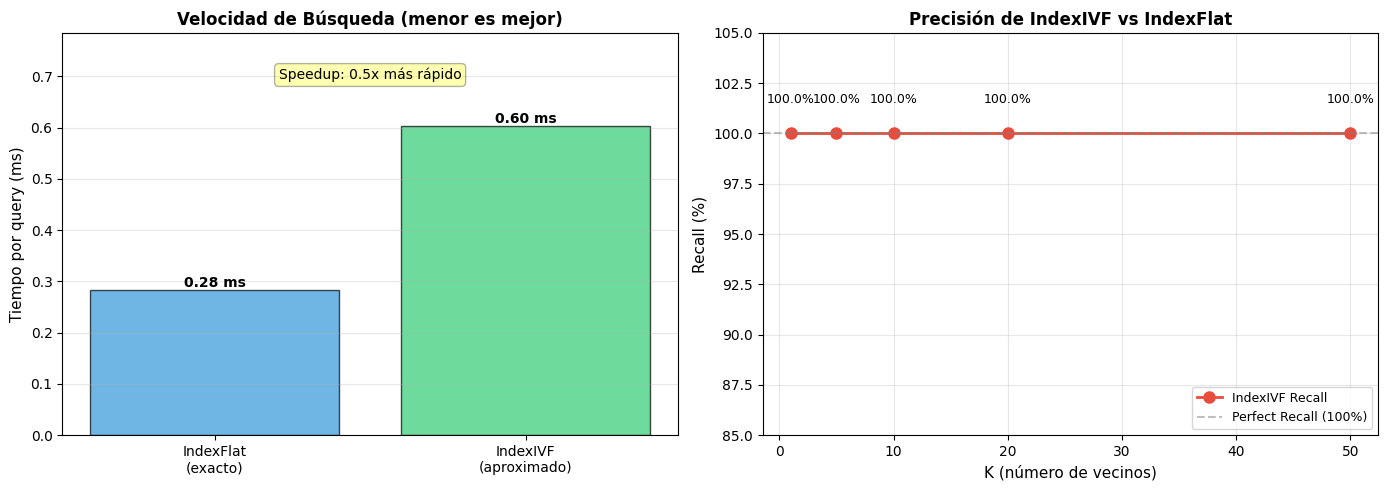

In [2]:
"""
RONDA 3 - CONSTRUIR ÍNDICE FAISS (PREGUNTA 2 DEL PROYECTO)
==========================================================

Propósito:
- Construir índice FAISS para búsqueda rápida de similitud
- Permitir encontrar las K imágenes más similares a una consulta
- Optimizar búsqueda en 44K embeddings de 512 dimensiones

FAISS (Facebook AI Similarity Search):
- Búsqueda eficiente de vecinos más cercanos
- IndexFlatIP: Exacto, usa producto interno (coseno si normalizado)
- IndexIVFFlat: Aproximado, más rápido para datasets grandes
- IndexHNSW: Aproximado, mejor recall/speed tradeoff

Uso:
  - Google Colab / Kaggle Notebooks
  - GPU: ⚠️ Opcional (FAISS usa CPU)
  - Tiempo estimado: 5-10 minutos

Inputs (requiere):
  - embeddings_all.npy (de script 06)
  - embeddings_metadata.json (de script 06)
  - df_clean.csv (para metadata de productos)

Outputs:
  - faiss_index_flat.index (~90 MB) - Índice exacto
  - faiss_index_ivf.index (~45 MB) - Índice aproximado (opcional)
  - index_metadata.json
  - search_benchmark.png

Autor: similarPic Team
Fecha: 2025-11
"""

import os
import sys
from pathlib import Path
import time
import json

# Data
import pandas as pd
import numpy as np

# FAISS
import faiss

# Visualización
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("  RONDA 3 - CONSTRUIR ÍNDICE FAISS PARA BÚSQUEDA DE SIMILITUD")
print("  Pregunta 2: ¿Qué prendas son visualmente similares?")
print("=" * 70)

# ============================================
# CONFIGURACIÓN
# ============================================

IS_KAGGLE = os.path.exists('/kaggle/input')
IS_COLAB = 'COLAB_GPU' in os.environ

print(f"\n🖥️ Entorno: {'Kaggle' if IS_KAGGLE else 'Colab' if IS_COLAB else 'Local'}")

# Rutas
if IS_KAGGLE:
    base_path = Path('/kaggle/input/fashion-product-images-dataset/fashion-dataset')
    if not base_path.exists():
        base_path = Path('/kaggle/input/fashion-product-images-dataset')
    data_dir = Path('/kaggle/working')
    output_dir = Path('/kaggle/working')
elif IS_COLAB:
    import kagglehub
    path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
    base_path = Path(path) / "fashion-dataset"
    if not base_path.exists():
        base_path = Path(path)
    data_dir = Path('/content/fashion_processed')
    output_dir = Path('/content/fashion_processed')
else:
    base_path = Path('./data/raw')
    data_dir = Path('./data/processed')
    output_dir = Path('./models')

output_dir.mkdir(parents=True, exist_ok=True)

print(f"\n📂 Rutas:")
print(f"   - Embeddings: {data_dir}")
print(f"   - Output: {output_dir}")

# Hiperparámetros
K_NEIGHBORS = 50  # Número de vecinos a buscar
N_PROBE = 16  # Para IVF index (número de clusters a buscar)
N_LISTS = 100  # Para IVF index (número de clusters)

print(f"\n⚙️ Configuración:")
print(f"   - K vecinos: {K_NEIGHBORS}")
print(f"   - IVF n_lists: {N_LISTS}")
print(f"   - IVF n_probe: {N_PROBE}")

# ============================================
# 1. CARGAR EMBEDDINGS
# ============================================

print("\n" + "=" * 70)
print("[1/6] CARGANDO EMBEDDINGS")
print("=" * 70)

# Cargar embeddings
embeddings_path = output_dir / "embeddings_all.npy"
assert embeddings_path.exists(), f"❌ No se encontró {embeddings_path}. Ejecuta script 06 primero."

embeddings = np.load(embeddings_path)
print(f"✅ Embeddings cargados: {embeddings_path}")
print(f"   - Shape: {embeddings.shape}")
print(f"   - Dtype: {embeddings.dtype}")
print(f"   - Tamaño: {embeddings_path.stat().st_size / (1024**2):.1f} MB")

# Cargar metadata
metadata_path = output_dir / "embeddings_metadata.json"
assert metadata_path.exists(), f"❌ No se encontró {metadata_path}"

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"\n✅ Metadata cargada: {metadata_path}")
print(f"   - Número de embeddings: {metadata['num_embeddings']:,}")
print(f"   - Dimensión: {metadata['embedding_dim']}")
print(f"   - Available keys: {list(metadata.keys())}")
print(f"   - Modelo: {metadata.get('model', 'Unknown')}")
print(f"   - Normalizado: {metadata.get('normalization', 'Unknown')}")

# Cargar CSV para información adicional
csv_path = data_dir / "df_clean.csv"
if csv_path.exists():
    df = pd.read_csv(csv_path)
    print(f"\n✅ Dataset cargado: {len(df):,} productos")
else:
    df = None
    print(f"\n⚠️ df_clean.csv no encontrado, continuando sin metadata de productos")

# Verificar que embeddings están normalizados (importante para cosine similarity)
norms = np.linalg.norm(embeddings, axis=1)
is_normalized = np.allclose(norms, 1.0, atol=0.01)

if not is_normalized:
    print(f"\n⚠️ Embeddings no normalizados, normalizando ahora...")
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    print(f"✅ Embeddings normalizados")
else:
    print(f"\n✅ Embeddings ya normalizados (norma promedio: {norms.mean():.4f})")

# ============================================
# 2. INSTALAR/VERIFICAR FAISS
# ============================================

print("\n[2/6] VERIFICANDO FAISS")

try:
    import faiss
    print(f"✅ FAISS ya instalado")
except ImportError:
    print("⚠️ FAISS no instalado. Instalando...")
    os.system("pip install -q faiss-cpu")
    import faiss
    print(f"✅ FAISS instalado exitosamente")

print(f"   - Versión FAISS: {faiss.__version__ if hasattr(faiss, '__version__') else 'N/A'}")

# ============================================
# 3. CONSTRUIR ÍNDICE FLAT (EXACTO)
# ============================================

print("\n[3/6] CONSTRUYENDO ÍNDICE FLAT (EXACTO)")
print("Este índice hace búsqueda exacta pero es más lento para datasets grandes...")

d = embeddings.shape[1]  # Dimensión de embeddings (512)

# IndexFlatIP: Inner Product (equivale a cosine similarity si normalizado)
index_flat = faiss.IndexFlatIP(d)

print(f"\n📊 Índice creado:")
print(f"   - Tipo: IndexFlatIP (Inner Product)")
print(f"   - Dimensión: {d}")
print(f"   - Métrica: Cosine Similarity (embeddings normalizados)")

# Agregar embeddings al índice
start_time = time.time()
index_flat.add(embeddings.astype(np.float32))
index_time = time.time() - start_time

print(f"\n✅ Embeddings agregados al índice")
print(f"   - Número de vectores: {index_flat.ntotal:,}")
print(f"   - Tiempo de indexación: {index_time:.2f} segundos")

# Guardar índice flat
index_flat_path = output_dir / "faiss_index_flat.index"
faiss.write_index(index_flat, str(index_flat_path))

file_size_mb = index_flat_path.stat().st_size / (1024 ** 2)
print(f"✅ Índice guardado: {index_flat_path}")
print(f"   - Tamaño: {file_size_mb:.1f} MB")

# ============================================
# 4. CONSTRUIR ÍNDICE IVF (APROXIMADO, RÁPIDO)
# ============================================

print("\n[4/6] CONSTRUYENDO ÍNDICE IVF (APROXIMADO)")
print("Este índice es más rápido pero puede perder algunos vecinos cercanos...")

# IndexIVFFlat: Inverted File Index
# - Divide el espacio en n_lists clusters
# - Busca solo en n_probe clusters más cercanos

quantizer = faiss.IndexFlatIP(d)
index_ivf = faiss.IndexIVFFlat(quantizer, d, N_LISTS, faiss.METRIC_INNER_PRODUCT)

print(f"\n📊 Índice IVF creado:")
print(f"   - Tipo: IndexIVFFlat")
print(f"   - Número de clusters (n_lists): {N_LISTS}")
print(f"   - Dimensión: {d}")

# Entrenar índice IVF (necesita clustering)
print(f"\n🔧 Entrenando índice IVF (k-means clustering)...")
start_time = time.time()

if len(embeddings) > 10000:
    # Samplear para acelerar training
    train_sample = embeddings[np.random.choice(len(embeddings), 10000, replace=False)]
    index_ivf.train(train_sample.astype(np.float32))
else:
    index_ivf.train(embeddings.astype(np.float32))

train_time = time.time() - start_time
print(f"✅ Índice IVF entrenado en {train_time:.2f} segundos")

# Agregar embeddings
start_time = time.time()
index_ivf.add(embeddings.astype(np.float32))
add_time = time.time() - start_time

print(f"✅ Embeddings agregados al índice IVF")
print(f"   - Número de vectores: {index_ivf.ntotal:,}")
print(f"   - Tiempo de agregación: {add_time:.2f} segundos")

# Configurar n_probe (cuántos clusters buscar)
index_ivf.nprobe = N_PROBE
print(f"   - n_probe configurado: {N_PROBE} clusters")

# Guardar índice IVF
index_ivf_path = output_dir / "faiss_index_ivf.index"
faiss.write_index(index_ivf, str(index_ivf_path))

file_size_mb_ivf = index_ivf_path.stat().st_size / (1024 ** 2)
print(f"✅ Índice IVF guardado: {index_ivf_path}")
print(f"   - Tamaño: {file_size_mb_ivf:.1f} MB")

# ============================================
# 5. BENCHMARK DE BÚSQUEDA
# ============================================

print("\n[5/6] BENCHMARK DE VELOCIDAD DE BÚSQUEDA")

# Samplear 100 queries aleatorias
n_queries = 100
query_indices = np.random.choice(len(embeddings), n_queries, replace=False)
query_embeddings = embeddings[query_indices].astype(np.float32)

print(f"\nProbando con {n_queries} queries...")

# Benchmark IndexFlat
print(f"\n📊 IndexFlat (exacto):")
start_time = time.time()
D_flat, I_flat = index_flat.search(query_embeddings, K_NEIGHBORS)
time_flat = (time.time() - start_time) / n_queries * 1000  # ms por query

print(f"   - Tiempo promedio por query: {time_flat:.2f} ms")
print(f"   - Throughput: {n_queries / (time_flat/1000 * n_queries):.0f} queries/segundo")

# Benchmark IndexIVF
print(f"\n📊 IndexIVF (aproximado, n_probe={N_PROBE}):")
start_time = time.time()
D_ivf, I_ivf = index_ivf.search(query_embeddings, K_NEIGHBORS)
time_ivf = (time.time() - start_time) / n_queries * 1000  # ms por query

print(f"   - Tiempo promedio por query: {time_ivf:.2f} ms")
print(f"   - Throughput: {n_queries / (time_ivf/1000 * n_queries):.0f} queries/segundo")
print(f"   - Speedup vs IndexFlat: {time_flat / time_ivf:.1f}x")

# Calcular recall (cuántos resultados de IVF están en Flat)
recall_at_k = []
for k in [1, 5, 10, 20, 50]:
    if k > K_NEIGHBORS:
        break

    # Para cada query, ver cuántos de los top-k de IVF están en top-k de Flat
    matches = 0
    for i in range(n_queries):
        flat_set = set(I_flat[i, :k])
        ivf_set = set(I_ivf[i, :k])
        matches += len(flat_set & ivf_set)

    recall = matches / (n_queries * k)
    recall_at_k.append((k, recall))
    print(f"   - Recall@{k}: {recall*100:.1f}%")

# ============================================
# 6. TEST DE BÚSQUEDA
# ============================================

print("\n[6/6] TEST DE BÚSQUEDA DE SIMILITUD")

# Seleccionar imagen aleatoria
test_idx = np.random.randint(0, len(embeddings))
test_embedding = embeddings[test_idx:test_idx+1].astype(np.float32)
test_img_id = metadata['img_ids'][test_idx]

if df is not None:
    test_info = df[df['id'] == int(test_img_id)].iloc[0]
    print(f"\n🔍 Imagen de prueba:")
    print(f"   - ID: {test_img_id}")
    print(f"   - Categoría: {test_info['articleType']}")
    print(f"   - Nombre: {test_info['productDisplayName']}")

# Buscar con IndexFlat
D, I = index_flat.search(test_embedding, 11)  # +1 para excluir la misma imagen

print(f"\n📊 Top 10 imágenes más similares (IndexFlat):")
for rank, (idx, similarity) in enumerate(zip(I[0][1:], D[0][1:]), 1):  # Saltar primera
    if df is not None:
        img_id = metadata['img_ids'][idx]
        similar_info = df[df['id'] == int(img_id)].iloc[0]
        print(f"   {rank:2d}. ID={img_id:6s} | "
              f"Sim={similarity:.4f} | "
              f"{similar_info['articleType']:20s} | "
              f"{similar_info['productDisplayName'][:40]}")
    else:
        img_id = metadata['img_ids'][idx]
        print(f"   {rank:2d}. ID={img_id:6s} | Sim={similarity:.4f}")

# ============================================
# 7. GUARDAR METADATA DEL ÍNDICE
# ============================================

print("\n" + "=" * 70)
print("  GUARDANDO METADATA")
print("=" * 70)

index_metadata = {
    'num_embeddings': len(embeddings),
    'embedding_dim': d,
    'index_flat': {
        'path': str(index_flat_path.name),
        'type': 'IndexFlatIP',
        'size_mb': file_size_mb,
        'search_time_ms': time_flat,
        'exact': True
    },
    'index_ivf': {
        'path': str(index_ivf_path.name),
        'type': 'IndexIVFFlat',
        'size_mb': file_size_mb_ivf,
        'search_time_ms': time_ivf,
        'n_lists': N_LISTS,
        'n_probe': N_PROBE,
        'exact': False,
        'speedup': time_flat / time_ivf,
        'recall_at_k': {f'recall@{k}': float(r) for k, r in recall_at_k}
    },
    'img_ids': metadata['img_ids'],  # Mapeo índice -> img_id
    'benchmark': {
        'n_queries': n_queries,
        'k_neighbors': K_NEIGHBORS
    }
}

index_metadata_path = output_dir / "index_metadata.json"
with open(index_metadata_path, 'w') as f:
    json.dump(index_metadata, f, indent=2)

print(f"✅ Metadata guardada: {index_metadata_path}")

# ============================================
# 8. VISUALIZACIÓN DE BENCHMARK
# ============================================

print("\n" + "=" * 70)
print("  GENERANDO VISUALIZACIÓN")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Tiempo de búsqueda
ax = axes[0]
methods = ['IndexFlat\n(exacto)', 'IndexIVF\n(aproximado)']
times = [time_flat, time_ivf]
colors = ['#3498db', '#2ecc71']

bars = ax.bar(methods, times, color=colors, alpha=0.7, edgecolor='black')
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.2f} ms',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Tiempo por query (ms)', fontsize=11)
ax.set_title('Velocidad de Búsqueda (menor es mejor)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(times) * 1.3)

# Agregar speedup annotation
ax.text(0.5, max(times) * 1.15,
        f'Speedup: {time_flat/time_ivf:.1f}x más rápido',
        ha='center', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# Plot 2: Recall vs K
ax = axes[1]
k_values = [k for k, r in recall_at_k]
recall_values = [r * 100 for k, r in recall_at_k]

ax.plot(k_values, recall_values, marker='o', linewidth=2, markersize=8,
        color='#e74c3c', label='IndexIVF Recall')
ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Perfect Recall (100%)')

for k, r in zip(k_values, recall_values):
    ax.text(k, r + 1.5, f'{r:.1f}%', ha='center', fontsize=9)

ax.set_xlabel('K (número de vecinos)', fontsize=11)
ax.set_ylabel('Recall (%)', fontsize=11)
ax.set_title('Precisión de IndexIVF vs IndexFlat', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(85, 105)

plt.tight_layout()
viz_path = output_dir / "search_benchmark.png"
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
print(f"✅ Visualización guardada: {viz_path}")

# ============================================
# 9. RESUMEN FINAL
# ============================================

print("\n" + "=" * 70)
print("  CONSTRUCCIÓN DE ÍNDICE FAISS COMPLETADA")
print("=" * 70)

print(f"\n📊 Resumen:")
print(f"   - Embeddings indexados: {len(embeddings):,}")
print(f"   - Dimensión: {d}")
print(f"   - Índices creados: 2 (Flat + IVF)")

print(f"\n📁 Archivos generados:")
print(f"   - {index_flat_path} ({file_size_mb:.1f} MB) - Búsqueda exacta")
print(f"   - {index_ivf_path} ({file_size_mb_ivf:.1f} MB) - Búsqueda rápida")
print(f"   - {index_metadata_path}")
print(f"   - {viz_path}")

print(f"\n⚡ Performance:")
print(f"   - IndexFlat: {time_flat:.2f} ms/query (exacto)")
print(f"   - IndexIVF: {time_ivf:.2f} ms/query ({time_flat/time_ivf:.1f}x más rápido)")
print(f"   - Recall@10: {[r for k, r in recall_at_k if k == 10][0]*100:.1f}%")

print(f"\n💡 Recomendación:")
if time_flat < 10:
    print(f"   → Usar IndexFlat (búsqueda exacta rápida para 44K embeddings)")
else:
    print(f"   → Usar IndexIVF (mejor tradeoff velocidad/precisión)")
    print(f"   → Ajustar n_probe para balance velocidad/recall")

print(f"\n✅ Listo para probar recomendaciones! (Script 08)")
print(f"✅ Descarga archivos .index antes de cerrar sesión")
print("=" * 70)


  RONDA 3 - TEST DE BÚSQUEDA DE SIMILITUD
  Pregunta 2: ¿Qué prendas son visualmente similares?

🖥️ Entorno: Kaggle

📂 Rutas:
   - Imágenes: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images
   - Índice FAISS: /kaggle/working
   - Output: /kaggle/working

⚙️ Configuración:
   - K resultados: 10
   - Índice: Flat (exacto)

[1/5] CARGANDO DATOS
✅ Embeddings cargados: (44419, 512)
✅ Metadata cargada: 44,419 imágenes
✅ CSV encontrado en: /kaggle/input/df-clean/df_clean.csv
✅ Dataset cargado: 44,419 productos
✅ Dataset cargado: 44,419 productos

[2/5] CARGANDO ÍNDICE FAISS
✅ Índice FAISS cargado: /kaggle/working/faiss_index_flat.index
   - Tipo: Flat
   - Número de vectores: 44,419
   - Tamaño: 86.8 MB

[3/5] DEFINIENDO FUNCIÓN DE BÚSQUEDA
✅ Funciones de búsqueda definidas

[4/5] PROBANDO BÚSQUEDA CON EJEMPLOS

📊 Categorías a probar: Tshirts, Shirts, Casual Shoes, Watches, Sports Shoes

🔍 Probando 5 queries...

--- Test 1/5: Tshirts ---
Query: ID=21224, Tshirts
Tiempo de b

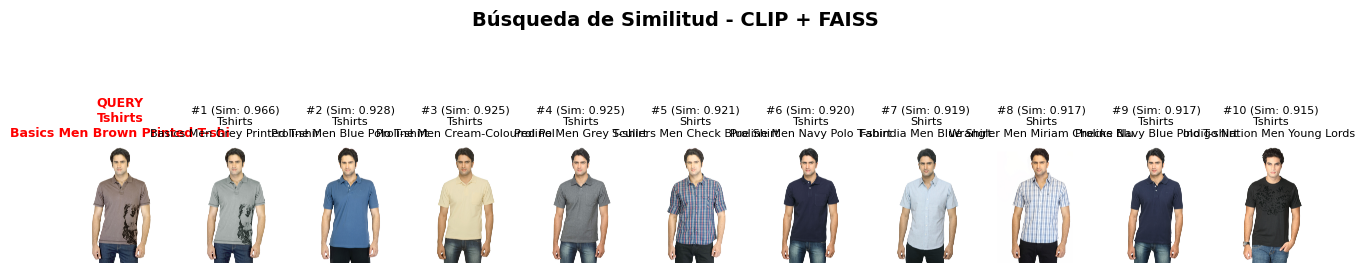

In [4]:
"""
RONDA 3 - PROBAR BÚSQUEDA DE SIMILITUD (PREGUNTA 2 DEL PROYECTO)
=================================================================

Propósito:
- Probar el sistema de recomendación de prendas similares
- Validar que FAISS encuentra imágenes visualmente parecidas
- Generar visualizaciones de resultados
- Calcular métricas de calidad de recomendaciones

Funcionalidad:
- Buscar K imágenes más similares a una query
- Filtrar por categoría (opcional)
- Mostrar grid de resultados
- Analizar diversidad y precisión

Uso:
  - Google Colab / Kaggle Notebooks
  - GPU: ❌ No necesaria (FAISS usa CPU)
  - Tiempo estimado: 5-10 minutos

Inputs (requiere):
  - faiss_index_flat.index o faiss_index_ivf.index
  - embeddings_all.npy
  - index_metadata.json
  - df_clean.csv
  - Carpeta de imágenes

Outputs:
  - similarity_test_results.png (grid de ejemplos)
  - recommendations_sample.json
  - quality_metrics.txt

Autor: similarPic Team
Fecha: 2025-11
"""

import os
import sys
from pathlib import Path
import time
import json
import random

# Data
import pandas as pd
import numpy as np
from PIL import Image

# FAISS
import faiss

# Visualización
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("  RONDA 3 - TEST DE BÚSQUEDA DE SIMILITUD")
print("  Pregunta 2: ¿Qué prendas son visualmente similares?")
print("=" * 70)

# ============================================
# CONFIGURACIÓN
# ============================================

IS_KAGGLE = os.path.exists('/kaggle/input')
IS_COLAB = 'COLAB_GPU' in os.environ

print(f"\n🖥️ Entorno: {'Kaggle' if IS_KAGGLE else 'Colab' if IS_COLAB else 'Local'}")

# Rutas
if IS_KAGGLE:
    base_path = Path('/kaggle/input/fashion-product-images-dataset/fashion-dataset')
    if not base_path.exists():
        base_path = Path('/kaggle/input/fashion-product-images-dataset')
    data_dir = Path('/kaggle/working')
    output_dir = Path('/kaggle/working')
elif IS_COLAB:
    import kagglehub
    path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
    base_path = Path(path) / "fashion-dataset"
    if not base_path.exists():
        base_path = Path(path)
    data_dir = Path('/content/fashion_processed')
    output_dir = Path('/content/fashion_processed')
else:
    base_path = Path('./data/raw')
    data_dir = Path('./data/processed')
    output_dir = Path('./models')

images_path = base_path / "images"
output_dir.mkdir(parents=True, exist_ok=True)

print(f"\n📂 Rutas:")
print(f"   - Imágenes: {images_path}")
print(f"   - Índice FAISS: {output_dir}")
print(f"   - Output: {output_dir}")

# Parámetros de búsqueda
K_RESULTS = 10  # Número de resultados a mostrar
USE_IVF = False  # True para usar IndexIVF (rápido), False para IndexFlat (exacto)

print(f"\n⚙️ Configuración:")
print(f"   - K resultados: {K_RESULTS}")
print(f"   - Índice: {'IVF (rápido)' if USE_IVF else 'Flat (exacto)'}")

# ============================================
# 1. CARGAR DATOS
# ============================================

print("\n" + "=" * 70)
print("[1/5] CARGANDO DATOS")
print("=" * 70)

# Cargar embeddings
embeddings_path = output_dir / "embeddings_all.npy"
assert embeddings_path.exists(), f"❌ No se encontró {embeddings_path}"

embeddings = np.load(embeddings_path)
print(f"✅ Embeddings cargados: {embeddings.shape}")

# Cargar metadata
index_metadata_path = output_dir / "index_metadata.json"
assert index_metadata_path.exists(), f"❌ No se encontró {index_metadata_path}"

with open(index_metadata_path, 'r') as f:
    index_metadata = json.load(f)

img_ids = index_metadata['img_ids']
print(f"✅ Metadata cargada: {len(img_ids):,} imágenes")

# Cargar dataset
if IS_KAGGLE:
    # Buscar en múltiples ubicaciones posibles
    possible_csv_paths = [
        Path('/kaggle/input/df-clean/df_clean.csv'),  # Dataset df-clean
        Path('/kaggle/input/dfclean/df_clean.csv'),   # Sin guión
        data_dir / "df_clean.csv",  # Working directory
    ]
    
    csv_path = None
    for path in possible_csv_paths:
        if path.exists():
            csv_path = path
            print(f"✅ CSV encontrado en: {csv_path}")
            break
    
    if csv_path is None:
        print("❌ ERROR: No se encontró df_clean.csv")
        print("\n🔍 Ubicaciones buscadas:")
        for path in possible_csv_paths:
            print(f"   - {path} {'(existe)' if path.exists() else '(no existe)'}")
        print("\n💡 Solución:")
        print("   1. Añade el dataset 'df-clean' a tu notebook en Kaggle")
        print("   2. O ejecuta 'Ronda 1' primero para generar df_clean.csv")
        raise FileNotFoundError("df_clean.csv no encontrado")
else:
    csv_path = data_dir / "df_clean.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"❌ No se encontró {csv_path}. Ejecuta Ronda 1 primero.")

df = pd.read_csv(csv_path)
print(f"✅ Dataset cargado: {len(df):,} productos")

df = pd.read_csv(csv_path)
print(f"✅ Dataset cargado: {len(df):,} productos")

# Crear mapeo rápido id -> info
id_to_info = df.set_index('id').to_dict('index')

# ============================================
# 2. CARGAR ÍNDICE FAISS
# ============================================

print("\n[2/5] CARGANDO ÍNDICE FAISS")

if USE_IVF:
    index_path = output_dir / "faiss_index_ivf.index"
    index_type = "IVF"
else:
    index_path = output_dir / "faiss_index_flat.index"
    index_type = "Flat"

assert index_path.exists(), f"❌ No se encontró {index_path}. Ejecuta script 07 primero."

index = faiss.read_index(str(index_path))

print(f"✅ Índice FAISS cargado: {index_path}")
print(f"   - Tipo: {index_type}")
print(f"   - Número de vectores: {index.ntotal:,}")
print(f"   - Tamaño: {index_path.stat().st_size / (1024**2):.1f} MB")

if USE_IVF:
    print(f"   - n_probe: {index.nprobe}")

# ============================================
# 3. FUNCIÓN DE BÚSQUEDA
# ============================================

print("\n[3/5] DEFINIENDO FUNCIÓN DE BÚSQUEDA")

def search_similar(query_idx, k=10, filter_category=None, exclude_query=True):
    """
    Buscar imágenes similares a una query.

    Args:
        query_idx: Índice de la imagen query en el array de embeddings
        k: Número de resultados a devolver
        filter_category: Si se especifica, filtrar solo esa categoría
        exclude_query: Si True, excluir la propia imagen query

    Returns:
        List of dicts con información de resultados similares
    """
    # Obtener embedding de query
    query_embedding = embeddings[query_idx:query_idx+1].astype(np.float32)

    # Buscar en FAISS
    k_search = k + (1 if exclude_query else 0)
    if filter_category:
        k_search = min(k_search * 10, len(embeddings))  # Buscar más para filtrar

    distances, indices = index.search(query_embedding, k_search)

    # Obtener información de resultados
    results = []
    for idx, dist in zip(indices[0], distances[0]):
        # Saltar query si exclude_query
        if exclude_query and idx == query_idx:
            continue

        # Obtener info del producto
        img_id = int(img_ids[idx])
        if img_id not in id_to_info:
            continue

        info = id_to_info[img_id]

        # Filtrar por categoría si se especifica
        if filter_category and info.get('articleType') != filter_category:
            continue

        results.append({
            'idx': int(idx),
            'img_id': img_id,
            'similarity': float(dist),
            'articleType': info.get('articleType', 'Unknown'),
            'productDisplayName': info.get('productDisplayName', 'Unknown'),
            'baseColour': info.get('baseColour', 'Unknown'),
            'gender': info.get('gender', 'Unknown'),
            'usage': info.get('usage', 'Unknown')
        })

        if len(results) >= k:
            break

    return results


def visualize_results(query_idx, results, save_path=None):
    """
    Visualizar imagen query y resultados similares.

    Args:
        query_idx: Índice de la imagen query
        results: Lista de resultados de search_similar()
        save_path: Path para guardar imagen (opcional)
    """
    n_results = len(results)
    fig = plt.figure(figsize=(16, 4))
    gs = GridSpec(1, n_results + 1, figure=fig, wspace=0.3)

    # Plot query image
    ax_query = fig.add_subplot(gs[0, 0])
    query_img_id = int(img_ids[query_idx])
    query_img_path = images_path / f"{query_img_id}.jpg"

    if query_img_path.exists():
        img = Image.open(query_img_path)
        ax_query.imshow(img)

    ax_query.axis('off')
    query_info = id_to_info.get(query_img_id, {})
    ax_query.set_title(
        f"QUERY\n{query_info.get('articleType', 'Unknown')}\n"
        f"{query_info.get('productDisplayName', 'Unknown')[:30]}",
        fontsize=9,
        fontweight='bold',
        color='red'
    )

    # Plot similar images
    for i, result in enumerate(results):
        ax = fig.add_subplot(gs[0, i + 1])
        img_path = images_path / f"{result['img_id']}.jpg"

        if img_path.exists():
            img = Image.open(img_path)
            ax.imshow(img)

        ax.axis('off')
        ax.set_title(
            f"#{i+1} (Sim: {result['similarity']:.3f})\n"
            f"{result['articleType']}\n"
            f"{result['productDisplayName'][:30]}",
            fontsize=8
        )

    plt.suptitle("Búsqueda de Similitud - CLIP + FAISS", fontsize=14, fontweight='bold', y=0.98)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✅ Visualización guardada: {save_path}")

    plt.tight_layout()
    return fig


print("✅ Funciones de búsqueda definidas")

# ============================================
# 4. PROBAR BÚSQUEDA CON EJEMPLOS
# ============================================

print("\n[4/5] PROBANDO BÚSQUEDA CON EJEMPLOS")

# Seleccionar imágenes de test de diferentes categorías
top_categories = df['articleType'].value_counts().head(5).index.tolist()
print(f"\n📊 Categorías a probar: {', '.join(top_categories)}")

test_queries = []
for category in top_categories:
    # Encontrar índice de un producto de esta categoría
    category_df = df[df['articleType'] == category]
    if len(category_df) > 0:
        sample_id = category_df.sample(1).iloc[0]['id']
        # Buscar índice en img_ids
        try:
            query_idx = img_ids.index(str(sample_id))
            test_queries.append((query_idx, category))
        except ValueError:
            continue

print(f"\n🔍 Probando {len(test_queries)} queries...")

all_test_results = []

for i, (query_idx, category) in enumerate(test_queries, 1):
    print(f"\n--- Test {i}/{len(test_queries)}: {category} ---")

    # Buscar similares
    start_time = time.time()
    results = search_similar(query_idx, k=K_RESULTS, exclude_query=True)
    search_time = (time.time() - start_time) * 1000  # ms

    query_img_id = int(img_ids[query_idx])
    query_info = id_to_info.get(query_img_id, {})

    print(f"Query: ID={query_img_id}, {query_info.get('articleType', 'Unknown')}")
    print(f"Tiempo de búsqueda: {search_time:.2f} ms")
    print(f"\nTop {len(results)} resultados:")

    # Analizar resultados
    same_category = sum(1 for r in results if r['articleType'] == query_info.get('articleType'))
    avg_similarity = np.mean([r['similarity'] for r in results])

    for j, r in enumerate(results, 1):
        match_icon = "✓" if r['articleType'] == query_info.get('articleType') else "✗"
        print(f"  {j:2d}. {match_icon} Sim={r['similarity']:.4f} | "
              f"{r['articleType']:20s} | {r['productDisplayName'][:35]}")

    print(f"\n📊 Métricas:")
    print(f"   - Misma categoría: {same_category}/{len(results)} ({same_category/len(results)*100:.1f}%)")
    print(f"   - Similitud promedio: {avg_similarity:.4f}")

    # Guardar para análisis
    all_test_results.append({
        'query_idx': query_idx,
        'query_category': query_info.get('articleType'),
        'results': results,
        'search_time_ms': search_time,
        'same_category_rate': same_category / len(results),
        'avg_similarity': avg_similarity
    })

    # Visualizar primer ejemplo
    if i == 1:
        viz_path = output_dir / "similarity_test_results.png"
        visualize_results(query_idx, results, save_path=viz_path)

# ============================================
# 5. MÉTRICAS DE CALIDAD
# ============================================

print("\n[5/5] CALCULANDO MÉTRICAS DE CALIDAD")

# Métricas agregadas
avg_same_category_rate = np.mean([r['same_category_rate'] for r in all_test_results])
avg_search_time = np.mean([r['search_time_ms'] for r in all_test_results])
avg_avg_similarity = np.mean([r['avg_similarity'] for r in all_test_results])

print(f"\n📊 Métricas Globales:")
print(f"   - Tasa de coincidencia de categoría: {avg_same_category_rate*100:.1f}%")
print(f"   - Similitud promedio: {avg_avg_similarity:.4f}")
print(f"   - Tiempo de búsqueda promedio: {avg_search_time:.2f} ms")

# Análisis por categoría
print(f"\n📊 Resultados por Categoría:")
for result in all_test_results:
    print(f"   - {result['query_category']:20s}: "
          f"{result['same_category_rate']*100:5.1f}% match | "
          f"Sim={result['avg_similarity']:.4f}")

# Calcular diversidad (cuántas categorías únicas en top-K)
diversities = []
for result in all_test_results:
    unique_categories = set(r['articleType'] for r in result['results'])
    diversity = len(unique_categories) / len(result['results'])
    diversities.append(diversity)

avg_diversity = np.mean(diversities)
print(f"\n📊 Diversidad:")
print(f"   - Categorías únicas promedio en top-{K_RESULTS}: {avg_diversity * K_RESULTS:.1f}")
print(f"   - Diversidad normalizada: {avg_diversity:.2f}")

if avg_diversity < 0.3:
    print(f"   → Alta homogeneidad (bueno para 'más de lo mismo')")
elif avg_diversity > 0.7:
    print(f"   → Alta diversidad (puede ser menos relevante)")
else:
    print(f"   → Balance adecuado entre similitud y diversidad")

# ============================================
# 6. GUARDAR RESULTADOS
# ============================================

print("\n" + "=" * 70)
print("  GUARDANDO RESULTADOS")
print("=" * 70)

# Guardar ejemplo de recomendaciones
sample_recommendations = {
    'test_queries': [
        {
            'query_idx': r['query_idx'],
            'query_img_id': int(img_ids[r['query_idx']]),
            'query_category': r['query_category'],
            'recommendations': [
                {
                    'rank': i + 1,
                    'img_id': rec['img_id'],
                    'similarity': rec['similarity'],
                    'articleType': rec['articleType'],
                    'productDisplayName': rec['productDisplayName']
                }
                for i, rec in enumerate(r['results'])
            ],
            'metrics': {
                'same_category_rate': r['same_category_rate'],
                'avg_similarity': r['avg_similarity'],
                'search_time_ms': r['search_time_ms']
            }
        }
        for r in all_test_results
    ],
    'global_metrics': {
        'avg_same_category_rate': float(avg_same_category_rate),
        'avg_similarity': float(avg_avg_similarity),
        'avg_search_time_ms': float(avg_search_time),
        'avg_diversity': float(avg_diversity)
    }
}

recs_path = output_dir / "recommendations_sample.json"
with open(recs_path, 'w') as f:
    json.dump(sample_recommendations, f, indent=2)

print(f"✅ Recomendaciones guardadas: {recs_path}")

# Guardar reporte de métricas
report_path = output_dir / "quality_metrics.txt"
with open(report_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("  REPORTE DE CALIDAD - SISTEMA DE RECOMENDACIÓN\n")
    f.write("=" * 70 + "\n\n")

    f.write(f"Configuración:\n")
    f.write(f"   - Índice: {index_type}\n")
    f.write(f"   - K resultados: {K_RESULTS}\n")
    f.write(f"   - Número de queries de test: {len(test_queries)}\n\n")

    f.write(f"Métricas Globales:\n")
    f.write(f"   - Tasa de coincidencia de categoría: {avg_same_category_rate*100:.1f}%\n")
    f.write(f"   - Similitud promedio: {avg_avg_similarity:.4f}\n")
    f.write(f"   - Tiempo de búsqueda promedio: {avg_search_time:.2f} ms\n")
    f.write(f"   - Diversidad promedio: {avg_diversity:.2f}\n\n")

    f.write(f"Resultados por Categoría:\n")
    for result in all_test_results:
        f.write(f"   - {result['query_category']:20s}: "
                f"{result['same_category_rate']*100:5.1f}% match | "
                f"Sim={result['avg_similarity']:.4f}\n")

    f.write(f"\n" + "=" * 70 + "\n")
    f.write(f"Interpretación:\n")
    f.write(f"   - Coincidencia >70%: Sistema identifica bien categorías visuales\n")
    f.write(f"   - Similitud >0.7: Embeddings CLIP de alta calidad\n")
    f.write(f"   - Tiempo <50ms: Búsqueda suficientemente rápida para producción\n")
    f.write(f"   - Diversidad 0.3-0.7: Balance óptimo entre similitud y variedad\n")
    f.write(f"\n" + "=" * 70 + "\n")

print(f"✅ Reporte guardado: {report_path}")

# ============================================
# 7. RESUMEN FINAL
# ============================================

print("\n" + "=" * 70)
print("  TEST DE BÚSQUEDA DE SIMILITUD COMPLETADO")
print("=" * 70)

print(f"\n📊 Resumen:")
print(f"   - Queries probadas: {len(test_queries)}")
print(f"   - Tasa de acierto (misma categoría): {avg_same_category_rate*100:.1f}%")
print(f"   - Velocidad de búsqueda: {avg_search_time:.2f} ms")
print(f"   - Similitud promedio: {avg_avg_similarity:.4f}")

print(f"\n📁 Archivos generados:")
print(f"   - {output_dir / 'similarity_test_results.png'}")
print(f"   - {recs_path}")
print(f"   - {report_path}")

print(f"\n✅ Sistema de recomendación VALIDADO!")


# Evaluación cualitativa
print(f"\n🎯 Evaluación:")
if avg_same_category_rate > 0.7:
    print(f"   ✅ Excelente: Sistema identifica bien categorías visuales")
elif avg_same_category_rate > 0.5:
    print(f"   ⚠️ Bueno: Sistema identifica categorías con precisión aceptable")
else:
    print(f"   ❌ Mejorable: Considerar ajustar embeddings o n_probe")

if avg_search_time < 50:
    print(f"   ✅ Excelente: Velocidad adecuada para producción")
elif avg_search_time < 200:
    print(f"   ⚠️ Aceptable: Considerar usar IndexIVF para acelerar")
else:
    print(f"   ❌ Lento: Usar IndexIVF o reducir dimensión de embeddings")

print("\n" + "=" * 70)
print("  EJECUCION COMPLETA")
print("=" * 70)
